In [1]:
import sys
sys.path.append("..")

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xgboost
from satreeverify.xgb_utils import *
from satreeverify.utils import disc_data, get_x_adv

/home/masoud/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = load_breast_cancer()
X = data['data']
y = data["target"]
feature_names = data["feature_names"]
y = y==1

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
ntrees = 50
clf = xgboost.XGBClassifier(n_estimators=ntrees, max_depth=3).fit(x_train, y_train)
clf.score(x_test, y_test)

/home/masoud/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9649122807017544

In [6]:
dump = clf.get_booster().get_dump(dump_format="json")
all_thresh = get_ens_thresh(dump)
data_ = disc_data(x_train[:2,:], all_thresh)
print(data_.shape)
data_.head()

(2, 126)


,1_21.4349995,3_696.25,24_0.13499999,26_0.21450001,24_0.10915,22_114.449997,13_22.6850014,21_25.6199989,23_650.949951,15_0.0148949996,...,28_0.282800019,20_14.4699993,1_16.5600014,23_646.449951,13_19.7900009,21_19.5050011,13_40.2200012,1_17.9949989,5_0.162949994,21_25.4749985
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,False,True


In [7]:
var_x = {f"x({i})": Bool(f"x({i})") for i in data_.columns}

# Soft Attack

In [8]:
epsilon = 0.34
index = 12

sample = X[index:index+1, :]
clf.predict_proba(sample)

array([[0.9983301 , 0.00166988]], dtype=float32)

In [9]:
s, c_weights = soft_attack(clf, sample, epsilon, var_x)

False
sat


In [10]:
adv_weights = get_output(s, c_weights)
1 / (1 + np.exp(-np.sum([v for k, v in adv_weights.items()])))

0.9034491636648164

In [11]:
clf.predict_proba(sample)[0][1]

0.0016698763

In [12]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.9034492

In [13]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
23,1332.000000,884.476488,0.335979,"[811.050049, 884.549988]"
1,24.800000,16.559836,0.332265,"[16.3950005, 16.5600014]"
21,29.940000,20.044460,0.330512,"[19.5050011, 20.0450001]"
7,0.111800,0.075060,0.328622,"[0.0500999987, 0.0750849992]"
20,20.960000,14.455529,0.310328,"[-inf, 14.4699993]"
27,0.176700,0.122178,0.308559,"[-inf, 0.122299999]"
22,151.700000,114.442997,0.245597,"[107.449997, 114.449997]"
26,0.363900,0.276791,0.239376,"[0.218050003, 0.276849985]"
28,0.317600,0.289144,0.089598,"[0.282800019, 0.28915]"
4,0.097400,0.089863,0.077380,"[0.0880350024, 0.0898649991]"


# Hard Attack

## weight distribution

In [14]:
w = np.asarray([v for k,v in c_weights.items()])
w.min(), w.max()

(-0.58273381, 0.573722661)

(array([ 1.,  5., 24., 21., 65., 63., 27., 15.,  4.,  1.]),
 array([-0.58273381, -0.46708816, -0.35144252, -0.23579687, -0.12015122,
        -0.00450557,  0.11114007,  0.22678572,  0.34243137,  0.45807701,
         0.57372266]),
 <BarContainer object of 10 artists>)

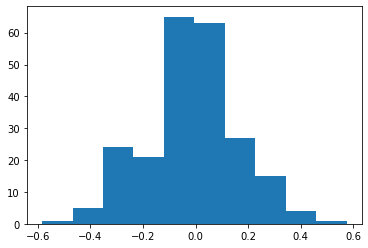

In [15]:
plt.hist(w)

## Attacking sample

In [16]:
epsilon = 0.34
index = 12

nbits = 8
sample = X[index:index+1, :]

In [17]:
s, c_weights, seq_nump, seq_numn = hard_attack(clf, sample, epsilon, var_x, nbits)

False
sat


In [18]:
clf.predict_proba(sample)[0][1]

0.0016698763

In [19]:
adv_weights = get_output(s, c_weights)
val = np.sum([v for k, v in adv_weights.items()])
1 / (1 + np.exp(-val))

0.5182350609024792

In [20]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.5182351

In [21]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
21,29.940000,20.044460,0.330512,"[19.5050011, 20.0450001]"
7,0.111800,0.075060,0.328622,"[0.0500999987, 0.0750849992]"
1,24.800000,16.999560,0.314534,"[16.5600014, 17.0]"
20,20.960000,14.455529,0.310328,"[-inf, 14.4699993]"
23,1332.000000,923.910551,0.306373,"[884.549988, 923.949951]"
24,0.103700,0.135101,0.302807,"[0.135100007, 0.136150002]"
22,151.700000,114.442997,0.245597,"[107.449997, 114.449997]"
26,0.363900,0.276791,0.239376,"[0.218050003, 0.276849985]"
27,0.176700,0.145399,0.177145,"[0.14395, 0.145400003]"
28,0.317600,0.357457,0.125495,"[0.35710001, inf]"
